In [1]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
import preprocessing 

# FOR REPRODUCIBILITY
np.random.seed(7)

/home/tony/dnn/anaconda2/envs/myjupyter/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# IMPORTING DATASET 
dataset = pd.read_csv('apple_share_price.csv', usecols=[1,2,3,4])
dataset = dataset.reindex(index = dataset.index[::-1])
#print dataset

# CREATING OWN INDEX FOR FLEXIBILITY
#obs = np.arange(1, len(dataset) + 1, 1)  # 建立 [1 ... 1664] index 作為繪圖 x 軸
#print obs

# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg_org = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

# PREPARATION OF TIME SERIES DATASE
OHLC_avg_rs = np.reshape(OHLC_avg_org.values, (len(OHLC_avg_org),1)) # 1664; 將矩陣從 1*1664 轉置成 1664*1
#print("OHLC_avg_rs: %r" % (OHLC_avg_rs))
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg_rs)  # normalize 到 [0, 1]
#print("OHLC_avg.scaler: %r" % (OHLC_avg))

# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]
print("train_OHLC.len:%d test_OHLC.len:%d" % (len(train_OHLC), len(test_OHLC)))
print("train_OHLC:%r" % (train_OHLC))

# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
isTnMod = True
if (isTnMod): #TonyH
    # FUNCTION TO CREATE 1D DATA INTO TIME SERIES DATASET
    def new_dataset_tn(dataset, step_size):
        data_X, data_Y = [], []
        for i in range(len(dataset)-step_size):
            a = dataset[i:(i+step_size), 0]
            data_X.append(a)
            data_Y.append(dataset[i + step_size, 0])
        return np.array(data_X), np.array(data_Y)
    trainX_ts, trainY = new_dataset_tn(train_OHLC, 1)
    testX_ts, testY   = new_dataset_tn(test_OHLC, 1)
else:
    trainX_ts, trainY = preprocessing.new_dataset(train_OHLC, 1)
    testX_ts, testY = preprocessing.new_dataset(test_OHLC, 1)
print("trainX_ts(len:%d):%r" % (len(trainX_ts), trainX_ts))
print("trainY(len:%d):%r" % (len(trainY), trainY))

# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX_ts, (trainX_ts.shape[0], 1, trainX_ts.shape[1]))
testX = np.reshape(testX_ts, (testX_ts.shape[0], 1, testX_ts.shape[1]))
step_size = 1
print("trainX.reshape:%r" % (trainX))

train_OHLC.len:1248 test_OHLC.len:416
train_OHLC:array([[0.01530745],
       [0.0196717 ],
       [0.02058364],
       ...,
       [0.57970731],
       [0.57634184],
       [0.57117422]])
trainX_ts(len:1247):array([[0.01530745],
       [0.0196717 ],
       [0.02058364],
       ...,
       [0.60029095],
       [0.57970731],
       [0.57634184]])
trainY(len:1247):array([0.0196717 , 0.02058364, 0.02347143, ..., 0.57970731, 0.57634184,
       0.57117422])
trainX.reshape:array([[[0.01530745]],

       [[0.0196717 ]],

       [[0.02058364]],

       ...,

       [[0.60029095]],

       [[0.57970731]],

       [[0.57634184]]])


In [3]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

# MODEL COMPILING
model.compile(loss='mean_squared_error', optimizer='adagrad') # Try SGD, adam, adagrad and compare!!!

# Training
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
 - 6s - loss: 0.0059
Epoch 2/5
 - 5s - loss: 3.3522e-04
Epoch 3/5
 - 5s - loss: 2.9413e-04
Epoch 4/5
 - 5s - loss: 2.5855e-04
Epoch 5/5
 - 5s - loss: 2.3314e-04


In [4]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# DE-NORMALIZING FOR PLOTTING
trainPredict_inv = scaler.inverse_transform(trainPredict)
trainY_inv = scaler.inverse_transform([trainY])
testPredict_inv = scaler.inverse_transform(testPredict)
testY_inv = scaler.inverse_transform([testY])

# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY_inv[0], trainPredict_inv[:,0]))
print('Train RMSE: %.2f' % (trainScore))

# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY_inv[0], testPredict_inv[:,0]))
print('Test RMSE: %.2f' % (testScore))
#print("testPredict_inv[:,0]:%r" % (testPredict_inv[:,0]))

Train RMSE: 1.69
Test RMSE: 2.69


testPredictPlot:array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]])
len(trainPredict_inv):1247 len(OHLC_avg):1664
testPredict_inv:array([[110.311485],
       [107.0871  ],
       [106.35754 ],
       [106.692635],
       [107.533035],
       [108.08446 ],
       [106.5532  ],
       [107.54917 ],
       [107.49272 ],
       [105.439575],
       [103.097694],
       [103.46699 ],
       [ 99.97073 ],
       [ 96.87876 ],
       [ 96.79802 ],
       [ 97.45505 ],
       [ 99.061745],
       [ 98.05594 ],
       [ 97.40284 ],
       [ 95.50378 ],
       [ 96.23598 ],
       [ 94.75267 ],
       [ 95.446724],
       [ 99.01977 ],
       [ 99.49753 ],
       [ 98.754944],
       [ 93.7018  ],
       [ 92.508446],
       [ 94.83546 ],
       [ 95.143524],
       [ 93.90548 ],
       [ 94.43468 ],
       [ 95.13575 ],
       [ 94.14544 ],
       [ 93.04535 ],
       [ 93.62965 ],
       [ 94.01383 ],
       [ 92.51101 ],
       [ 92.739525],
      

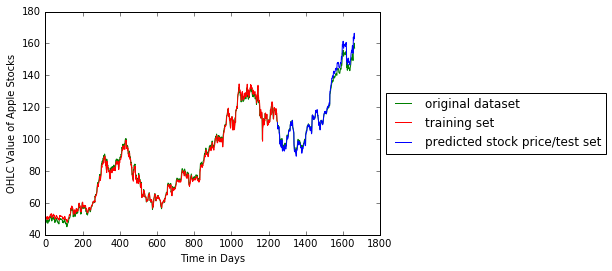

In [5]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict_inv)+step_size, :] = trainPredict_inv

# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
print("testPredictPlot:%r" % (testPredictPlot))
print("len(trainPredict_inv):%d len(OHLC_avg):%d" % (len(trainPredict_inv), len(OHLC_avg)))
print("testPredict_inv:%r" % (testPredict_inv))
if (isTnMod):
    testPredictPlot[len(trainPredict_inv)+step_size:len(OHLC_avg)-1, :] = testPredict_inv
else:
    testPredictPlot[len(trainPredict_inv)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict_inv

# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
#plt.legend(loc = 'upper right')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.show()

In [12]:
# PREDICT FUTURE VALUES
last_val = testPredict_inv[-1]
print("last_val:%r" % (last_val))
last_val_scaled = last_val/last_val
print("last_val_scaled:%r" % (last_val_scaled))

next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("next_val:%r" % (next_val))
print "Last Day Value:", np.asscalar(last_val)
print "Next Day Value:", np.asscalar(last_val*next_val)
# print np.append(last_val, next_val)

last_val:array([163.27925], dtype=float32)
last_val_scaled:array([1.], dtype=float32)
array([[[1.]]], dtype=float32)
next_val:array([[1.0541729]], dtype=float32)
Last Day Value: 163.279251099
Next Day Value: 172.124557495


In [19]:
if (isTnMod):
    last_val = OHLC_avg_rs[-1]
    print("last_val:%r" % (last_val))
    last_val_nl = scaler.transform([last_val])
    print("last_val_nl:%r" % (last_val_nl))
    last_val_rs = np.reshape(last_val_nl[0], (1,1,1))
    print("last_val_rs:%r" % (last_val_rs))
    
    next_val = model.predict(last_val_rs)
    print("next_val:%r" % (next_val))
    next_val_dn = scaler.inverse_transform(next_val)
    print("next_val_dn:%r" % (next_val_dn))

last_val:array([157.18])
last_val_nl:array([[0.97398819]])
last_val_rs:array([[[0.97398819]]])
next_val:array([[1.0241271]], dtype=float32)
next_val_dn:array([[162.953]], dtype=float32)


In [25]:
def future_prediction(price):
    last_val = np.array([[price]], np.float32)
    last_val_nl = scaler.transform(last_val)
    last_val_rs = np.reshape(last_val_nl[0], (1,1,1))
    next_val = model.predict(last_val_rs)
    next_val_dn = scaler.inverse_transform(next_val)
    print("next_val_dn:%r" % (next_val_dn))
    
future_prediction(157.48)
future_prediction(163.29944)
future_prediction(170.02231)
future_prediction(177.78561)
future_prediction(186.72789)

next_val_dn:array([[163.29944]], dtype=float32)
next_val_dn:array([[170.02231]], dtype=float32)
next_val_dn:array([[177.78561]], dtype=float32)
next_val_dn:array([[186.72789]], dtype=float32)
next_val_dn:array([[196.97264]], dtype=float32)
